# BeatBag
This is an entry in the SparkFun Crowdsourcing Algorithms Contest: https://www.sparkfun.com/news/2115

In [154]:
import numpy as np
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline  

In [159]:
def lpf(alpha, x, y_old):
    return (y_old + alpha * (x - y_old))

def hpf(alpha, x, x_old, y_old):
    return (alpha * (y_old + x - x_old))

def vector_mag(x,y):
    return (np.sqrt(x**2 + y**2))

def goertzel(samples, sample_rate, *freqs):
    """
    Lifted from this guy: https://gist.github.com/sebpiq/4128537
    
    Implementation of the Goertzel algorithm, useful for calculating individual
    terms of a discrete Fourier transform.
    `samples` is a windowed one-dimensional signal originally sampled at `sample_rate`.
    The function returns 2 arrays, one containing the actual frequencies calculated,
    the second the coefficients `(real part, imag part, power)` for each of those frequencies.
    For simple spectral analysis, the power is usually enough.
    Example of usage :
        
        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """
    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Calculate all the DFT bins we have to compute to include frequencies
    # in `freqs`.
    bins = set()
    for f_range in freqs:
        f_start, f_end = f_range
        k_start = int(math.floor(f_start / f_step))
        k_end = int(math.ceil(f_end / f_step))

        if k_end > window_size - 1: raise ValueError('frequency out of range %s' % k_end)
        bins = bins.union(range(k_start, k_end))

    # For all the bins, calculate the DFT term
    n_range = range(0, window_size)
    freqs = []
    results = []
    for k in bins:

        # Bin frequency and coefficients for the computation
        f = k * f_step_normalized
        w_real = 2.0 * math.cos(2.0 * math.pi * f)
        w_imag = math.sin(2.0 * math.pi * f)

        # Doing the calculation on the whole sample
        d1, d2 = 0.0, 0.0
        for n in n_range:
            y  = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Storing results `(real part, imag part, power)`
        results.append((
            0.5 * w_real * d1 - d2, w_imag * d1,
            d2**2 + d1**2 - w_real * d1 * d2)
        )
        freqs.append(f * sample_rate)
    return freqs, results

## Locate the data

In [156]:
data_path = '.\\data\\Recorded Tests\\'
#data_path +=  '3-77hits.TXT'
#data_path +=  '4-81hits.TXT'
data_path +=  '5-93hits.TXT'
#data_path +=  '6-79hits.TXT'
#data_path +=  'MysteryDataSet-1.TXT'
#data_path +=  'MysteryDataSet-2.TXT'

## Initialize variables

In [157]:
sampletime = 0.002
timeconstant_lpf = 0.4
alpha_lpf = (float)(sampletime / (sampletime+timeconstant_lpf))

timeconstant_hpf = 0.6
alpha_hpf = (float)(sampletime / (sampletime+timeconstant_hpf))

x_lpf=0.0
y_lpf=0.0
z_lpf=0.0

x_lpf_old=0.0
y_lpf_old=0.0
z_lpf_old=0.0

x_hpf=0.0
y_hpf=0.0
z_hpf=0.0

x_hpf_old=0.0
y_hpf_old=0.0
z_hpf_old=0.0

## Read and process each line of the file

In [193]:
hitcount = 0
#myvec=0

with open(data_path, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        try:           
            timestamp_ms, x, y, z = row
        except ValueError:
            pass
        
        x=float(x)
        y=float(y)
        z=float(z)            

        #Signal Processing
        #for now, this is lowpass followed by high pass filters.
        #later, time dependent filter vaules
        x_lpf = lpf(alpha_lpf, x, x_lpf)
        x_hpf = hpf(alpha_hpf, x_lpf, x_lpf_old, x_hpf_old)
        x_lpf_old = x_lpf
        x_hpf_old = x_hpf
        
        y_lpf = lpf(alpha_lpf, y, y_lpf)
        y_hpf = hpf(alpha_hpf, y_lpf, y_lpf_old, y_hpf_old)
        y_lpf_old = y_lpf
        y_hpf_old = y_hpf

        z_lpf = lpf(alpha_lpf, z, z_lpf)
        z_hpf = hpf(alpha_hpf, z_lpf, z_lpf_old, z_hpf_old)
        z_lpf_old = z_lpf
        z_hpf_old = z_hpf        
                
        #calculate a vector in plane of the bag platform
        c = vector_mag(x_hpf, y_hpf)   

        myvec_z=np.append(myvec,float(max(z_hpf,0)))
        myvec_c=np.append(myvec,float(c))        
        
#        plt.plot(float(timestamp_ms)/1000.0, z_hpf, 'ro')
        
        #hit_count_logic
        if (c > .1): #every punch imparts a force in the plane of the platform
            if (z_hpf<-.1): #and toward the ground
                hitcount+=1
                print float(timestamp_ms)/1000, c, z_hpf                
                

print hitcount

plt.show()

4.885 0.247326490941 -0.179023966272
10.13 0.128720983431 -0.121975988361
10.446 0.124485461764 -0.101965183863
11.976 0.126521545238 -0.224469199261
12.264 0.119516457397 -0.182327086284
12.902 0.107046196618 -0.117620371061
13.806 0.124329389515 -0.113982631369
14.117 0.178714591111 -0.106200757342
14.119 0.102056222036 -0.104844935261
15.087 0.127683174304 -0.102745669523
17.112 0.18569490711 -0.236013747657
18.043 0.156098616614 -0.143088639479
18.548 0.261483217433 -0.234589523438
19.097 0.116381025979 -0.125879272283
19.121 0.227285704693 -0.218191344165
20.342 0.15929309536 -0.150570961665
20.816 0.117274482632 -0.158363713163
20.837 0.261868163188 -0.129448401975
21.791 0.102561940493 -0.125441564794
21.995 0.157633745499 -0.142443917063
22.87 0.1680194264 -0.101075091302
24.06 0.117416144026 -0.234501361639
24.343 0.250020098627 -0.190928834709
24.418 0.366010740609 -0.162213275332
24.617 0.19517490629 -0.140692808529
26.095 0.145078999406 -0.234025342647
26.696 0.143544044497

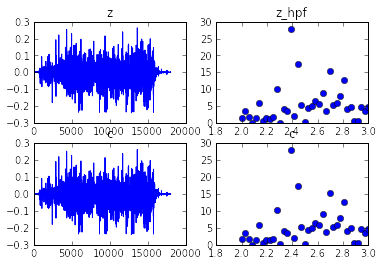

In [194]:
plt.subplot(2,2,1)
plt.title('z')
plt.plot(myvec_z)

plt.subplot(2,2,2)
plt.title('z_hpf')
freqs, results = goertzel(myvec_z, 1/0.002, (2, 3))
plt.plot(freqs, np.array(results)[:,2], 'o')

plt.subplot(2,2,3)
plt.title('c')
plt.plot(myvec_c)

plt.subplot(2,2,4)
plt.title('c')
freqs, results = goertzel(myvec_c, 1/0.002, (2, 3))
plt.plot(freqs, np.array(results)[:,2], 'o')

plt.show()

In [191]:
print freqs

[1.9995556542990447, 2.0273272606087533, 2.055098866918463, 2.0828704732281715, 2.1106420795378806, 2.1384136858475893, 2.1661852921572984, 2.1939568984670075, 2.221728504776716, 2.2495001110864252, 2.2772717173961343, 2.305043323705843, 2.3328149300155525, 2.360586536325261, 2.38835814263497, 2.4161297489446794, 2.443901355254388, 2.4716729615640967, 2.4994445678738058, 2.527216174183515, 2.554987780493224, 2.5827593868029326, 2.6105309931126417, 2.638302599422351, 2.6660742057320594, 2.6938458120417685, 2.7216174183514776, 2.7493890246611863, 2.7771606309708954, 2.8049322372806045, 2.832703843590313, 2.8604754499000222, 2.8882470562097313, 2.91601866251944, 2.943790268829149, 2.971561875138858, 2.9993334814485673]
